In [1]:
import numpy as np
import getdist
import matplotlib.pyplot as plt
from getdist import plots
plt.rcParams.update(plt.rcParamsDefault)

import disSat as dis

from colossus.cosmology import cosmology
from colossus.halo import mass_so
from colossus.halo import mass_defs
from colossus.halo import mass_adv
from colossus.halo import profile_nfw
from colossus.halo import profile_einasto
from colossus.halo import concentration
from scipy.integrate import quad
from scipy.integrate import quadrature
from scipy.special import erf

from disSat.vutils import menc
from disSat.vutils import mvir2sigLOS
from disSat.vutils import Reff as R_eff
from disSat.genutils import cNFW
from disSat.genutils import moster13 as m13
from disSat.baryons.smhm import Moster13
from disSat.baryons.galaxy_size import Read17
from disSat.dark_matter.concentrations import Diemer19

cosmo = cosmology.setCosmology('planck18')

%matplotlib inline

Removed no burn in


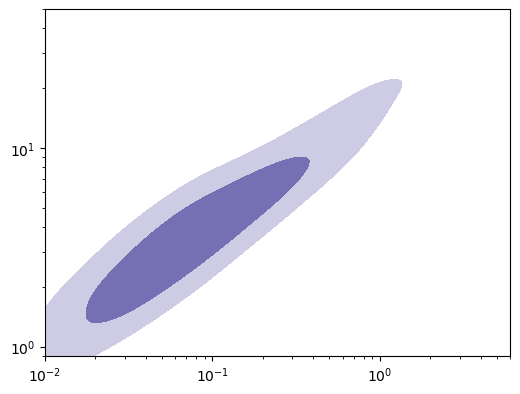

In [3]:
# NO CC

plt.rcParams.update(plt.rcParamsDefault)

#define the scatter constants

scatter_smhm = 0.15
scatter_concentration = 0.16
scatter_rhalf2D = 0.234
factor = np.log(10)

#define mass range

n=100000
M200_presample1 = np.geomspace(1e7, 1e12, n)

#subsample once based on mass function

#subsample again based on halo occupation fraction

alpha=1.31
Mhof=10**8.35
hofprob = .5 + .5*erf(alpha*np.log10(M200_presample1/Mhof))

mprob=(M200_presample1**(-.83)) * hofprob
mprob/=np.sum(mprob)
M200 = np.random.choice(M200_presample1, n, p=mprob)

#compute Rvir for later use

R200 = mass_so.M_to_R(M200*cosmo.h, 1, '200c') / cosmo.h

#compute concentration

c200 = np.random.lognormal(mean=np.log(cNFW(M200, z=1, massdef='200c')), sigma=(scatter_concentration * factor))

#compute stellar mass (I made the relation manually because I originally thought it was different originally, but then realized
# that it's just moster13 function from dis)

def smhm(mhalo):
    N = 0.046
    M0 = 1.5*10**12
    Beta=0.963
    if type(mhalo)=='numpy.ndarray':
        Mstar=np.array([])
        for m in mhalo:
            Mstar_value=(m*N)*((m/M0)**Beta)
            Mstar=np.append(Mstar, Mstar_value)
            return Mstar
    else:
        Mstar=(mhalo*N)*((mhalo/M0)**Beta)
        return Mstar

sm=smhm(M200)

m_stellar = np.random.lognormal(mean=np.log(sm), sigma=(scatter_smhm * factor))

#compute Reff and sigLOS for each model

Reff_CDM=np.array([])
sigLOS_CDM=np.array([])

for i, m in enumerate(M200):
    if m < 10**9:
        prof='NFW'
    else:
        prof='coreNFW'
    Reff_CDM_value = np.random.lognormal(mean=np.log(R_eff(m, profile=prof, mstar = m_stellar[i], c200=c200[i], zin=1)), sigma=(scatter_rhalf2D * factor))
    Reff_CDM = np.append(Reff_CDM, Reff_CDM_value)
    sigLOS_CDM_value = mvir2sigLOS(m, profile=prof, c200=c200[i], mstar=m_stellar[i], Re0=Reff_CDM[i])
    sigLOS_CDM=np.append(sigLOS_CDM, sigLOS_CDM_value)

#compute observation probability    
    
def n_prof_NFW(r, rs, n0):
    return n0 / ((r/rs)*((1+r/rs)**2))

r_s = R200/c200

n0values1 = np.array([])
for i, o in enumerate(R200):
    result1, _ = quad(lambda r: 4*np.pi*(r**2)*n_prof_NFW(r, rs=r_s[i], n0=1), 1e-3, o)
    n0value = M_mw/result1
    n0values1 = np.append(n0values1, n0value)

C_rtop = np.array([])
for i, o in enumerate(R200):
    result2, __ = quad(lambda r: (4*np.pi)**(1)*n_prof_NFW(r, rs=r_s[i], n0=n0values1[i])*(r**2), 1e-3, o)
    C_rtop = np.append(C_rtop, result2)

L = m_stellar / 2
r_c = 1.5 * L**0.51

C_rbottom = np.array([])
for i, o in enumerate(r_c):
    result3, ___ = quad(lambda r: (4*np.pi)**(1)*n_prof_NFW(r, rs=r_s[i], n0=n0values1[i])*(r**2), 1e-3, o)
    C_rbottom = np.append(C_rbottom, result3)

Omega = 3.65
C_r = C_rtop / C_rbottom
C_omega = (4*np.pi) / Omega
C=C_r*C_omega
Pobs=1/C

#plot Reff vs sigLOS taking into account observation probability and occupation fraction

y=np.random.rand(len(M200))
    
g = plots.get_single_plotter()

param1 = np.log10(Reff_CDM[y < Pobs])  
param2 = np.log10(sigLOS_CDM[y < Pobs])  

# Create the samples object
samples = getdist.MCSamples(
    samples=np.column_stack((param1, param2)),
    names=["log10_Reff", "log10_sigma"]
)

# We obtain the contours using getdist
parx, pary = g.get_param_array(samples, ['log10_Reff', 'log10_sigma'])
dens = g.sample_analyser.get_density_grid(samples, parx, pary)

# We plot the contours
plt.xscale('log')
plt.yscale('log')
plt.contourf(10**dens.x, 10**dens.y, dens.P,
             levels=list(dens.getContourLevels([0.9545, 0.6827])) + [1e99], colors=["#7570b35a", "#7570b3", ""])
plt.xlim(.01, 6)
plt.ylim(0.9,50)
plt.show()

Removed no burn in


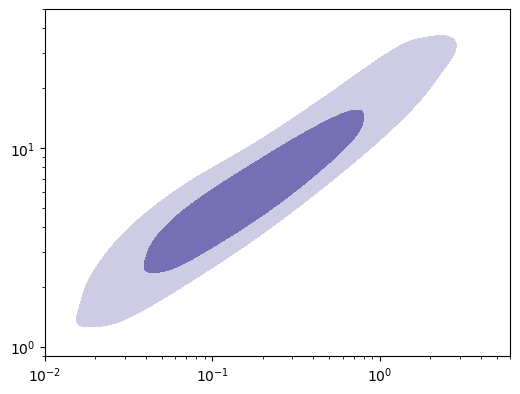

In [2]:
# CC

plt.rcParams.update(plt.rcParamsDefault)

#define the scatter constants

scatter_smhm = 0.15
scatter_concentration = 0.16
scatter_rhalf2D = 0.234
factor = np.log(10)

#define mass range

n=100000
M200_presample1 = np.geomspace(1e7, 1e12, n)

#subsample once based on mass function

#subsample again based on halo occupation fraction

alpha=1.31
Mhof=10**8.35
hofprob = .5 + .5*erf(alpha*np.log10(M200_presample1/Mhof))

mprob=(M200_presample1**(-.83)) * hofprob
mprob/=np.sum(mprob)
M200 = np.random.choice(M200_presample1, n, p=mprob)

#compute Rvir for later use

R200 = mass_so.M_to_R(M200*cosmo.h, 1, '200c') / cosmo.h

#compute concentration

conc = Diemer19()
c200 = conc(M200, z=1)

#compute stellar mass (I made the relation manually because I originally thought it was different originally, but then realized
# that it's just moster13 function from dis)

moster13 = Moster13()
m_stellar = moster13(M200, z=1)

#compute Reff and sigLOS for each model

Reff_CDM=np.array([])
sigLOS_CDM=np.array([])

R__eff = Read17()

for i, m in enumerate(M200):
    if m < 10**9:
        prof='NFW'
    else:
        prof='coreNFW'
    Reff_CDM_value = np.random.lognormal(mean=np.log(R_eff(m, profile=prof, mstar = m_stellar[i], c200=c200[i], zin=1)), sigma=(scatter_rhalf2D * factor))
    Reff_CDM = np.append(Reff_CDM, Reff_CDM_value)
    sigLOS_CDM_value = mvir2sigLOS(m, profile=prof, c200=c200[i], mstar=m_stellar[i], Re0=Reff_CDM[i])
    sigLOS_CDM=np.append(sigLOS_CDM, sigLOS_CDM_value)

#compute observation probability    
    
def n_prof_NFW(r, rs, n0):
    return n0 / ((r/rs)*((1+r/rs)**2))

M_mw = 10**12
Rvir_mw = mass_so.M_to_R(M_mw*cosmo.h, 0, '200c') / cosmo.h
c_mw = 9
r_s_mw = Rvir_mw/c_mw

C_rtop = np.array([])
result2, __ = quad(lambda r: n_prof_NFW(r, rs=r_s_mw, n0=1)*(r**2), 1e-3, Rvir_mw)
C_rtop = np.append(C_rtop, result2)

L = m_stellar / 2
r_c = 1.5 * L**0.51

C_rbottom = np.array([])
n0values2 = np.array([])
r_s = R200/c200

for i, o in enumerate(r_c):
    result4, ___ = quad(lambda r: n_prof_NFW(r, rs=r_s_mw, n0=1)*(r**2), 1e-3, o)
    C_rbottom = np.append(C_rbottom, result4)

Omega = 3.65
C_r = C_rtop / C_rbottom
C_omega = (4*np.pi) / Omega
C=C_r*C_omega
Pobs=1/C

for i, o in enumerate(m_stellar):
    threshold = 4e5
    if o > threshold:
        Pobs[i]=1

#plot Reff vs sigLOS taking into account observation probability and occupation fraction

y=np.random.rand(len(M200))
    
g = plots.get_single_plotter()

param1 = np.log10(Reff_CDM[y < Pobs])  
param2 = np.log10(sigLOS_CDM[y < Pobs])  

# Create the samples object
samples = getdist.MCSamples(
    samples=np.column_stack((param1, param2)),
    names=["log10_Reff", "log10_sigma"]
)

# We obtain the contours using getdist
parx, pary = g.get_param_array(samples, ['log10_Reff', 'log10_sigma'])
dens = g.sample_analyser.get_density_grid(samples, parx, pary)

# We plot the contours
plt.xscale('log')
plt.yscale('log')
plt.contourf(10**dens.x, 10**dens.y, dens.P,
             levels=list(dens.getContourLevels([0.9545, 0.6827])) + [1e99], colors=["#7570b35a", "#7570b3", ""])
plt.xlim(.01, 6)
plt.ylim(0.9,50)
plt.show()